## Working with Behavior Dataset

It follows the [LeRobot](https://huggingface.co/lerobot) format with some customizations for better data handling. The dataset has the following structure:

| Folder       | Description                                                    |
|--------------|----------------------------------------------------------------|
| annotations  | language annotations for each episode                          |
| data         | low dim data, including proprioceptions, actions, privileged task info, etc. |
| meta         | metadata folder                                                |
| videos       | visual observations, including rgb, depth, seg_instance_id     |

### Downloading demonstration data

You can make use of `omnigibson.learning.datas.BehaviorLeRobotDataset` for fine-grained data download, for which you can specify which task to download, how many episodes per task, which observation modalities, which camera to use. Below is an example of downloading / loading the demonstration dataset using this class.


Alternatively, If you want to fresh download everything at once, you can use the `snapshot_download` method from huggingface API:

```
snapshot_download(
    repo_id="behavior-1k/2025-challenge-demos",
    repo_type="dataset",
    revision="v2.1",
    local_dir=$PATH_TO_LOCAL_DIR,
    max_workers=$NUM_CPU - 2  
    force_download=True
)
```

In [1]:
from omnigibson.learning.datas.lerobot_dataset import BehaviorLeRobotDataset

# Path to your dataset root
DATASET_PATH = "/scr/behavior/2025-challenge-demos"

# Create the dataset
ds = BehaviorLeRobotDataset(
    repo_id="behavior-1k/2025-challenge-demos",
    root=DATASET_PATH,
    episodes=range(2),  # load the first 2 demos for each task
    # Note that data download does not support per-episode granularity, 
    # so it will download all episodes for the two tasks, then load the first 2 demos
    tasks=["turning_on_radio", "picking_up_trash"], # Only load turning_on_radio and picking_up_trash
    modalities=["rgb", "depth", "seg_instance_id"], # load all available modalities
    cameras=["head"],   # only load head camera
    local_only=False,   # download missing files from HF if any
    force_cache_sync=True,  # force sync cache with HF
    # change this and local_only to True to save loading time if you already have the data installed 
)
print("Dataset size:", len(ds))

Fetching ... files: 0it [00:00, ?it/s]

Fetching ... files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset size: 15095


## Loading and using demonstration dataset

To use the demonstration dataset, one solution is to keep working with `BehaviorLeRobotDataset` with which you can randomly access the data as shown below:

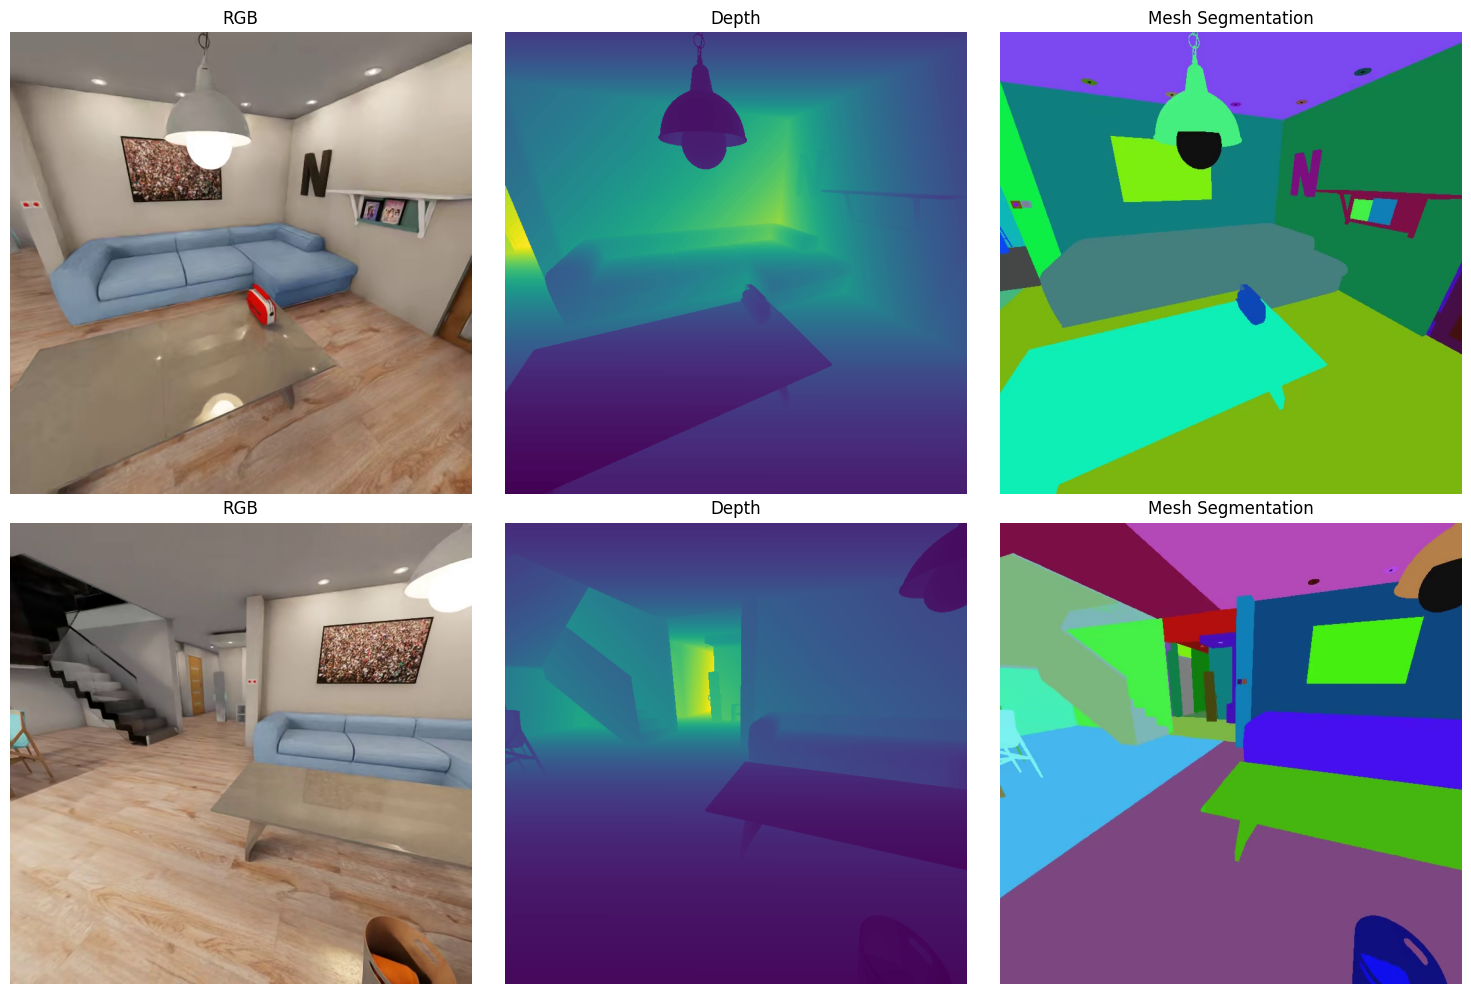

In [3]:
import matplotlib.pyplot as plt

# Random access a frame
sample_first, sample_last = ds[0], ds[-1]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0, 0].imshow(sample_first["observation.images.rgb.head"].movedim(-3, -1))
axes[0, 0].set_title("RGB")
axes[0, 0].axis("off")
axes[0, 1].imshow(sample_first["observation.images.depth.head"])
axes[0, 1].set_title("Depth")
axes[0, 1].axis("off")
axes[0, 2].imshow(sample_first["observation.images.seg_instance_id.head"].movedim(-3, -1))
axes[0, 2].set_title("Mesh Segmentation")
axes[0, 2].axis("off")
axes[1, 0].imshow(sample_last["observation.images.rgb.head"].movedim(-3, -1))
axes[1, 0].set_title("RGB")
axes[1, 0].axis("off")
axes[1, 1].imshow(sample_last["observation.images.depth.head"])
axes[1, 1].set_title("Depth")
axes[1, 1].axis("off")
axes[1, 2].imshow(sample_last["observation.images.seg_instance_id.head"].movedim(-3, -1))
axes[1, 2].set_title("Mesh Segmentation")
axes[1, 2].axis("off")

plt.tight_layout()
plt.show()

Alternatively, we also provide `omnigibson.learning.datas.BehaviorIterableDataset`, which is a iterable-style dataset that preload low dim parquet files and lazily load visual observations from MP4 files. It is ddp-ready and provide nice configurability, including setting observation window size, action chunking, action prediction horizon, etc. Here we show a demo of loading the first 2 turning_on_radio trajectories using this dataset (assuming you have already run the code above to download them).

In [12]:
from omnigibson.learning.datas import BehaviorIterableDataset   

first_2_demos = BehaviorIterableDataset.get_all_demo_keys(
    data_path=DATASET_PATH.rsplit("/", 1)[0], 
    task_names=["turning_on_radio"]
)[:2]

iterable_ds = BehaviorIterableDataset(
    data_path=DATASET_PATH.rsplit("/", 1)[0],
    demo_keys=first_2_demos,
    obs_window_size=2,
    ctx_len=8,
    action_prediction_horizon=16,
    downsample_factor=3,    # downsample to 10Hz
    visual_obs_types=["rgb"],
    multi_view_cameras={"head": {
        "name": "robot_r1::robot_r1:zed_link:Camera:0",
        "resolution": [240, 240]
    }}  # camera config, see omnigibson/learning/configs/robot/r1pro.yaml
)


In [18]:
batch = next(iter(iterable_ds))
print("keys: ", batch.keys())
print("base actions: ", batch["actions"]["base"])

keys:  dict_keys(['obs', 'actions', 'masks'])
base actions:  tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.1565],
        [ 0.0000,  0.0000, -0.2501],
        [ 0.0000,  0.0000, -0.2746]])
